# Incorporating long-range consistency in CNN-based texture generation

This notebook provides the code of "Incorporating long-range consistency in CNN-based texture generation" by G. Berger and  R. Memisevic (http://arxiv.org/abs/1606.01286).

Notebook built on top of https://github.com/Lasagne/Recipes/blob/master/examples/styletransfer/Art%20Style%20Transfer.ipynb which provides an implementation of the algorithm described in "A Neural Algorithm of Artistic Style" (http://arxiv.org/abs/1508.06576) by Gatys, Ecker and Bethge. 

## Import 

In [1]:
import lasagne
import numpy as np
import pickle
import skimage.transform
import scipy
from scipy.ndimage.morphology import binary_erosion
import time

import theano
import theano.tensor as T

from lasagne.utils import floatX

import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX 850M (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 4007)
C:\Python27\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## CNN definition

In [2]:
# VGG-19, 19-layer model from the paper:
# "Very Deep Convolutional Networks for Large-Scale Image Recognition"
# Original source: https://gist.github.com/ksimonyan/3785162f95cd2d5fee77
# License: non-commercial use only

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

IMAGE_H, IMAGE_W = 384, 384

# Note: tweaked to use average pooling instead of maxpooling
def build_model():
    net = {}
    net['input'] = InputLayer((1, 3, IMAGE_H, IMAGE_W))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2, mode='average_exc_pad')
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2, mode='average_exc_pad')
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2, mode='average_exc_pad')
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2, mode='average_exc_pad')
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2, mode='average_exc_pad')

    return net

### Build the VGG-19 net

In [3]:
# Download the normalized pretrained weights from:
# https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl
# (original source: https://bethgelab.org/deepneuralart/)

#!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl

In [4]:
# build VGG net and load weights
net = build_model()

values = pickle.load(open('vgg19_normalized.pkl', 'rb'))['param values']
lasagne.layers.set_all_param_values(net['pool5'], values)

### Preprocessing functions

In [5]:
MEAN_VALUES = np.array([103.939, 116.779, 123.68]).reshape((3,1,1))
IMAGE_W, IMAGE_H = 384, 384

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    
    # Resize
    im = skimage.transform.resize(im, (IMAGE_H, IMAGE_W), preserve_range=True)
    
    # Save rawim
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert RGB to BGR
    im = im[::-1, :, :]

    im = im.astype('float32') - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

def deprocess(x):
    x = np.copy(x[0])
    x += MEAN_VALUES

    x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Mask function used when inpainting
def mask_img(img, margin):
    mask = np.ones((IMAGE_H, IMAGE_W))
    mask[margin:-margin,margin:-margin] = 0.
    img[margin:-margin,margin:-margin, :] = [128, 128, 128]
    eroded_mask = binary_erosion(mask, np.ones((15,15)), iterations=1, border_value=1)
    return img, eroded_mask

## Gram matrices and losses definition

### Partial losses

In [6]:
def batch_flatten(x):
    x = T.reshape(x, (x.shape[0], T.prod(x.shape) // x.shape[0]))
    return x

# Gram matrix defined as in [Gatys et al.]
def gram_matrix(x):
    features = batch_flatten(x[0,:,:,:])
    g = T.dot(features, T.transpose(features))
    return g

# Gram matrices on spatially transformed feature maps
def shifted_gramm_matrix(x, shiftX=1, shiftY=0):
    X,Y = x.shape[2:4]
    features_pdelta = batch_flatten(x[0,:,shiftX:,shiftY:])
    features_mdelta = batch_flatten(x[0,:,:X-shiftX,:Y-shiftY])
    g = T.dot(features_pdelta, T.transpose(features_mdelta))
    return g

def LR_flipped_gram_matrix(x):
    features = batch_flatten(x[0,:,:,:])
    flipped_features = batch_flatten(x[0,:,:,::-1])
    g = T.dot(features, T.transpose(flipped_features))
    return g

def UD_flipped_gram_matrix(x):
    features = batch_flatten(x[0,:,:,:])
    flipped_features = batch_flatten(x[0,:,::-1,:])
    g = T.dot(features, T.transpose(flipped_features))
    return g

# Losses (as in [Gatys et al.])
def content_loss(P, X, layer, mask=None):
    p = P[layer]
    x = X[layer]
    
    N = x.shape[1]
    M = x.shape[2] * x.shape[3]
    
    if mask is not None:
        x = x*mask
        p = p*mask
        
    loss = (1./(2*N * M))* ((x - p)**2).sum()
    return loss


def style_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * ((G - A)**2).sum()
    return loss

# New losses
def cross_correlation_loss(A, X, shiftX, shiftY, layer):
    a = A[layer]
    x = X[layer]
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    A_x = shifted_gramm_matrix(a, shiftX, 0)
    G_x = shifted_gramm_matrix(x, shiftX, 0)
    A_y = shifted_gramm_matrix(a, 0, shiftY)
    G_y = shifted_gramm_matrix(x, 0, shiftY)
    
    loss = 1./(8 * N**2 * M**2)*(((G_x - A_x)**2) + (G_y - A_y)**2).sum()
    return loss

def flip_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    A_lr = LR_flipped_gram_matrix(a)
    G_lr = LR_flipped_gram_matrix(x)
    A_ud = UD_flipped_gram_matrix(a)
    G_ud = UD_flipped_gram_matrix(x)
    
    loss = 1./(8 * N**2 * M**2)*(((G_lr - A_lr)**2) + (G_ud - A_ud)**2).sum()
    return loss

# Not used
def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()

### Total loss

In [7]:
def get_total_loss(params, x_features, a_features, c_features=None):
    losses = []
    layers = params["layers"]
    # Style losses
    if params["style_weight"]>0.:
        for name in layers:
            losses.append((params["style_weight"]/len(layers))*style_loss(a_features, x_features, name))
    # Cross correlation losses
    if params["cc_weight"]>0.:
        for i, name in enumerate(layers):
            deltas = params["deltas"][i]
            for d in deltas:
                losses.append((params["cc_weight"]/len(layers))*cross_correlation_loss(a_features, x_features, 
                                                                                       d, d, name))
    # Flip losses
    if params["flip_weight"]>0.:
        for name in layers:
            losses.append((params["flip_weight"]/len(layers))*flip_loss(a_features, x_features, name))
    # Content losses
    if params["content_weight"]>0.:
        for name in params["content_layers"]:
            losses.append((params["content_weight"]/len(params["content_layers"]))*content_loss(c_features, x_features, name,
                                                                                                params["content_mask"]))
    return T.sum(losses)

## Optimizers

In [8]:
class Evaluator(object):
    def __init__(self, f_grad_and_loss, generated_image):
        self.loss_value = None
        self.grads_values = None
        self.eval_func = f_grad_and_loss
        self.generated_image = generated_image

    def eval_loss_and_grads(self, x):
        x = floatX(x.reshape((1, 3, IMAGE_H, IMAGE_W)))
        outs = self.eval_func(x)
        self.loss_value = outs[0]
        if len(outs[1:]) == 1:
            self.grad_values = outs[1].flatten().astype('float64')
        else:
            self.grad_values = np.array(outs[1:]).flatten().astype('float64')

    def loss(self, x):
        self.eval_loss_and_grads(x)
        return self.loss_value

    def grads(self, x):
        return self.grad_values

def optimize(total_loss, grad, generated_image, init, nb_iterations):
    # Theano functions to evaluate loss and gradient
    f_grad_and_loss = theano.function([generated_image], [total_loss, grad]) 

    # Evaluator
    evaluator = Evaluator(f_grad_and_loss, generated_image)

    x0 = init.astype('float64')
    xs = []
    xs.append(x0)
    
    bounds = np.repeat([(-103.939, 255. - 103.939, -116.779, 255.0 - 116.779, -123.68, 255 - 123.68)],
                       np.product(x0.shape) // 3, axis=0).reshape((np.product(x0.shape), 2))

    # Optimize, saving the result periodically
    start = time.time()
    for i in range(nb_iterations):
        start_iter = time.time()
        x0, _, _ = scipy.optimize.fmin_l_bfgs_b(evaluator.loss, x0.flatten(), fprime=evaluator.grads, maxfun=40, 
                                     bounds=bounds, factr = 1e7, pgtol = 1e-12)
        #x0 = generated_image.astype('float64')
        end_iter = time.time()
        print "\rIteration %d took %.2f s."%(i, end_iter-start_iter),
        xs.append(x0.reshape((1, 3, IMAGE_H, IMAGE_W)))
    print "\rGeneration took %.2f s."%(end_iter-start)
    return xs

### Setting all together

In [9]:
def generate(params, reference, content=None, init=None, nb_iterations=10):
    all_layers = list(set(params["layers"]+params["content_layers"]))
    # Precompute layer activations for photo and artwork
    layers = {k: net[k] for k in all_layers}
    input_im_theano = T.tensor4()
    outputs = lasagne.layers.get_output(layers.values(), input_im_theano)
    
    # Get features for each image
    # Reference texture
    rawim, reference = prep_image(reference)
    ref_features = {k: theano.shared(output.eval({input_im_theano: reference}))
                    for k, output in zip(layers.keys(), outputs)}
    # Content (if given)
    if content is not None:
        rawim, content = prep_image(content)
        con_features = {k: theano.shared(output.eval({input_im_theano: content}))
                      for k, output in zip(layers.keys(), outputs)}
    else:
        con_features = None
    # Image to generate
    generation = T.tensor4()
    gen_features = lasagne.layers.get_output(layers.values(), generation)
    gen_features = {k: v for k, v in zip(layers.keys(), gen_features)}
    # Compute the total loss
    total_loss = get_total_loss(params, gen_features, ref_features, con_features)
    # and the gradient with respect to the image being generated
    grad = T.grad(total_loss, generation)
    # Initialization 
    if init is not None:
        rawim, init = prep_image(init)
    else:
        init = np.random.uniform(-128, 128, (1, 3, IMAGE_H, IMAGE_W))
    init = floatX(init)
    # Optimize with L-BFGS
    images = optimize(total_loss, grad, generation, init, nb_iterations)
    return images

# APPLICATIONS

# A - Texture Generation

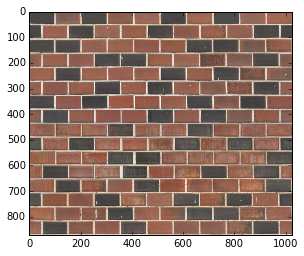

In [10]:
IMAGE_H, IMAGE_W = 192, 192

reference = plt.imread('images/texture_generation/bricks.jpg')
plt.imshow(reference)

### [Gatys et al.]

To get the result of *[Gatys et al.]*, you just need to be sure that **params["cc_weight"]** and **params["flip_weight"]** are **set to 0**. 

In [11]:
nb_iterations = 8
params = dict()
params["layers"] = ['conv1_1', 'pool1', 'pool2', 'pool3', 'pool4']
params["style_weight"] = 1e6
params["cc_weight"] = 0
params["deltas"] = []
params["flip_weight"] = 0
params["content_layers"] = []
params["content_weight"] = 0
params["content_mask"] = None

Generation took 42.08 s.


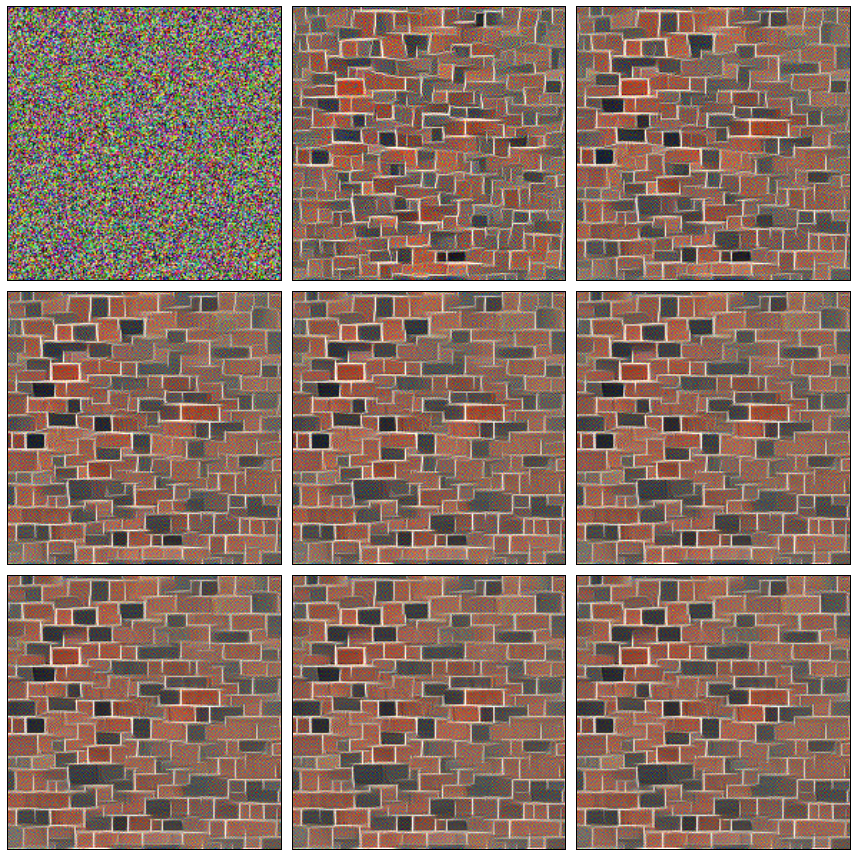

In [12]:
out = generate(params, reference, nb_iterations=nb_iterations)

plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)    
    plt.imshow(deprocess(out[i]))
plt.tight_layout()

### Ours

Adding **cross-correlation terms** to the loss.

In [13]:
# Removing 'conv1_1' from the layers being considered
params["layers"] = ['pool1', 'pool2', 'pool3', 'pool4']
# Adding cross correlation terms
params["cc_weight"] = 1e6
# with the corresponding delta values:
nb_terms_per_layer = [6,5,4,3]
params["deltas"] = [[2 ** (i + 1) for i in range(nb)] for nb in nb_terms_per_layer]
print "Deltas used for each layer:", params["deltas"]

Deltas used for each layer: [[2, 4, 8, 16, 32, 64], [2, 4, 8, 16, 32], [2, 4, 8, 16], [2, 4, 8]]


Generation took 69.60 s.


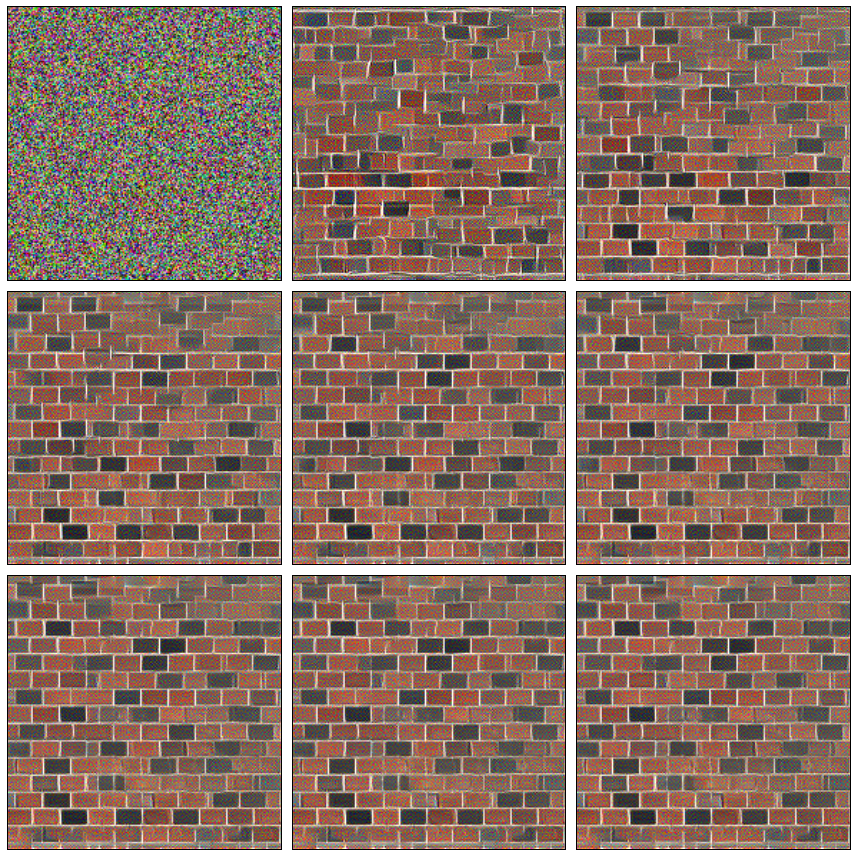

In [14]:
out = generate(params, reference, nb_iterations=nb_iterations)

plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)    
    plt.imshow(deprocess(out[i]))
plt.tight_layout()

# B - Inpainting

The **MARGIN** parameter determines the area to inpaint.

In [22]:
IMAGE_H, IMAGE_W = 384, 384
MARGIN = 34 

content = plt.imread('images/inpainting/red_leaves_init.jpg')
reference = plt.imread('images/inpainting/red_leaves_ref.jpg')

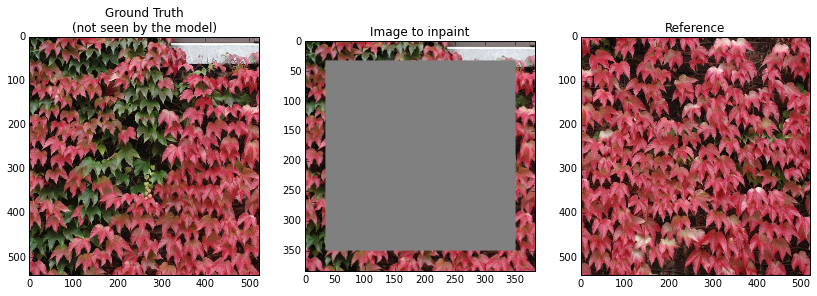

In [23]:
plt.figure(figsize=(14,5))
plt.subplot(131)
plt.title("Ground Truth\n(not seen by the model)")
plt.imshow(content)
plt.subplot(132)
plt.title("Image to inpaint")
raw_content, content = prep_image(content)
masked_content, mask = mask_img(raw_content, MARGIN)
plt.imshow(masked_content)
plt.subplot(133)
plt.title("Reference")

plt.imshow(reference)
plt.show()

In [24]:
nb_iterations = 8
params = dict()
params["layers"] = ['pool1', 'pool2', 'pool3', 'pool4']
params["style_weight"] = 1e6
params["cc_weight"] = 1e6
nb_terms_per_layer = [6,5,4,3]
params["deltas"] = [[2 ** (i + 1) for i in range(nb)] for nb in nb_terms_per_layer]
params["flip_weight"] = 0
# Add a constraint on borders using a content loss on 'input' and an eroded mask
params["content_layers"] = ["input"]
params["content_weight"] = 1e3
params["content_mask"] = T.as_tensor_variable(np.dstack((mask,mask,mask)).transpose(2,0,1)[None])

Generation took 240.16 s.


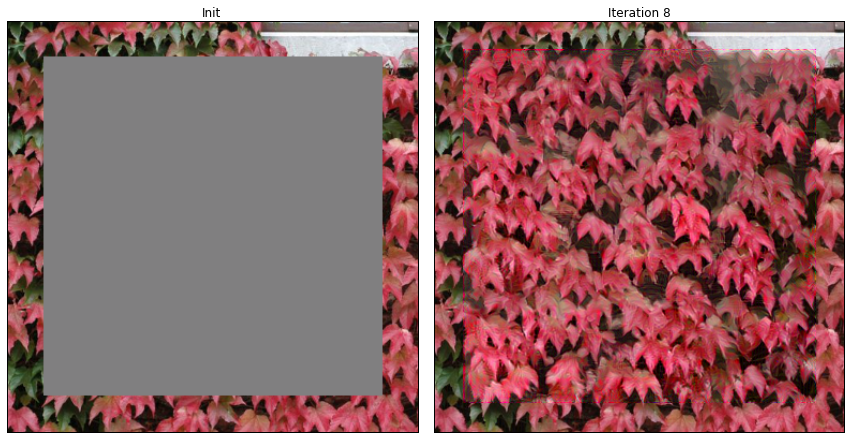

In [25]:
out = generate(params, reference, content=masked_content, init=masked_content, nb_iterations=nb_iterations)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("Init")
plt.gca().xaxis.set_visible(False)    
plt.gca().yaxis.set_visible(False)    
plt.imshow(deprocess(out[0]))
plt.subplot(122)
plt.title("Iteration %d"%nb_iterations)
plt.gca().xaxis.set_visible(False)    
plt.gca().yaxis.set_visible(False)    
plt.imshow(deprocess(out[-1]))
plt.tight_layout()

# C - Season Transfer

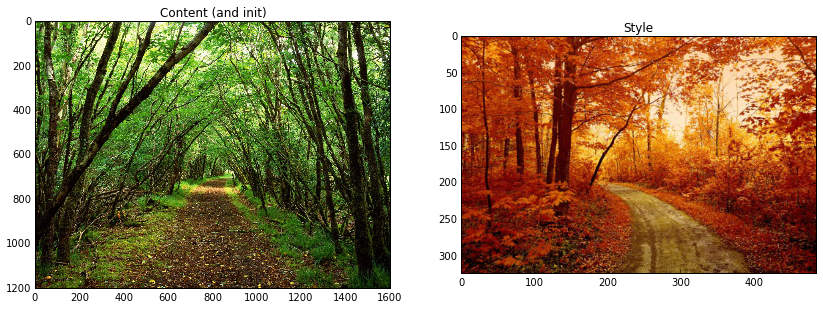

In [26]:
IMAGE_H, IMAGE_W = 288, 384
content = plt.imread('images/season_transfer/forest_road_summer.jpg')
style = plt.imread('images/season_transfer/forest_road_autumn.jpg')

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.title("Content (and init)")
plt.imshow(content)
plt.subplot(122)
plt.title("Style")
plt.imshow(style)
plt.show()

In [27]:
nb_iterations = 8
params = dict()
params["layers"] = ['pool1', 'pool2', 'pool3', 'pool4']
params["style_weight"] = 1e6
params["cc_weight"] = 1e6
nb_terms_per_layer = [6,5,4,3]
params["deltas"] = [[2 ** (i + 1) for i in range(nb)] for nb in nb_terms_per_layer]
params["flip_weight"] = 0
# Add a content loss on 'pool4'
params["content_weight"] = 1e5
params["content_layers"] = ["pool4"]
params["content_mask"] = None

Generation took 186.87 s.


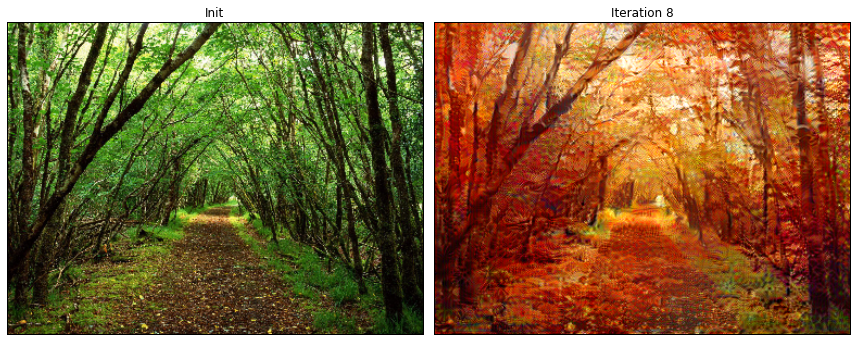

In [28]:
out = generate(params, style, content=content, init=content, nb_iterations=nb_iterations)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("Init")
plt.gca().xaxis.set_visible(False)    
plt.gca().yaxis.set_visible(False)    
plt.imshow(deprocess(out[0]))
plt.subplot(122)
plt.title("Iteration %d"%nb_iterations)
plt.gca().xaxis.set_visible(False)    
plt.gca().yaxis.set_visible(False)    
plt.imshow(deprocess(out[-1]))
plt.tight_layout()

# D- Symmetric Textures

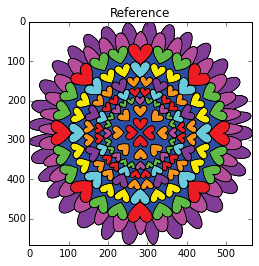

In [29]:
IMAGE_H, IMAGE_W = 384, 384
reference = plt.imread('images/symmetric_textures/symmetry2.jpg')

plt.figure()
plt.title("Reference")
plt.imshow(reference)
plt.show()

In [30]:
IMAGE_H, IMAGE_W = 192, 192
nb_iterations = 8
params = dict()
params["layers"] = ['pool1', 'pool2', 'pool3', 'pool4']
params["style_weight"] = 1e6
params["cc_weight"] = 0
params["deltas"] = []
params["flip_weight"] = 1e6
# Add a content loss on 'pool4'
params["content_weight"] = 0
params["content_layers"] = []
params["content_mask"] = None

Generation took 47.85 s.


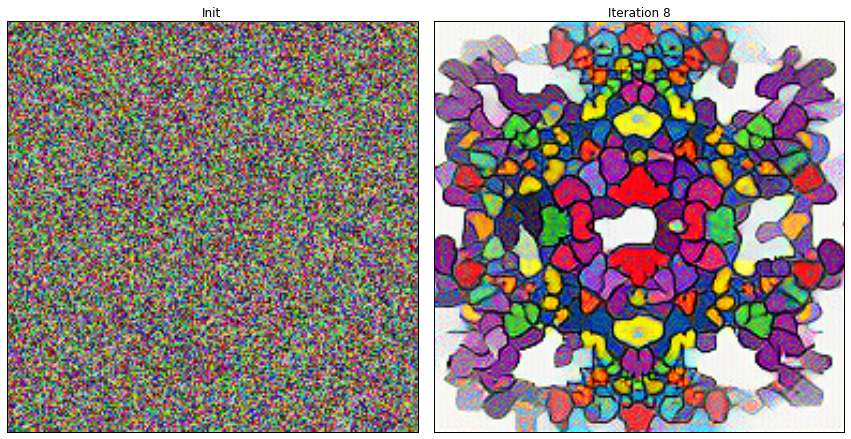

In [31]:
out = generate(params, reference, nb_iterations=nb_iterations)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("Init")
plt.gca().xaxis.set_visible(False)    
plt.gca().yaxis.set_visible(False)    
plt.imshow(deprocess(out[0]))
plt.subplot(122)
plt.title("Iteration %d"%nb_iterations)
plt.gca().xaxis.set_visible(False)    
plt.gca().yaxis.set_visible(False)    
plt.imshow(deprocess(out[-1]))
plt.tight_layout()